## 순환 신경망 이해하기
지금까지 사용한 신경망의 특징은 메모리가 없다는 것  
-> 네트워크에 주입되는 입력은 개별적으로 처리되며 입력 간에 유지되는 상태가 없음  
-> 전체 시퀀스를 하나의 데이터 포인트로 변환해야 함  

이전에 다뤘던 [IMDB 문제에서](https://nuyhc.github.io/deep%20learning/06_Text_Seq_intro/) 영화 리뷰 하나를 큰 벡터 하나로 변환해 처리  
-> 피드포워드 네트워크(feedforward network)  

사람이 문장을 읽는 것처럼 이전에 나온 것을 기억하면서 단어별로 또는 한눈에 들어오는 만큼씩 처리 가능  
-> 문장에 있는 의미를 자연스럽게 표현하도록 도와줌  
-> 극단적으로 단순화시킨 버전이 **순환 신경망(Recurrent Neural Network, RNN)** 임  

### RNN
시퀀스의 원소를 순회하면서 처리한 정보를 **상태(state)** 에 저장  
-> 내부에 루프(loop)를 갖는 신경망의 한 종류  
-> RNN의 상태는 2개의 다른 시퀀스를 처리하는 사이에 재설정

In [2]:
# 간단한 RNN 정방향 계산
import numpy as np

timesteps = 100 # 입력 시퀀스에 있는 타임스텝의 수
input_features = 32 # 입력 특성의 차원
output_features = 64 # 출력 특성의 차원

inputs = np.random.random((timesteps, input_features))

state_t = np.zeros((output_features)) # 초기 상태

W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features))

successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t

final_output_sequence = np.stack(successive_outputs, axis=0)

In [3]:
inputs

array([[0.67098837, 0.23079513, 0.5434262 , ..., 0.38224125, 0.12011091,
        0.73089334],
       [0.0635489 , 0.21060464, 0.18464099, ..., 0.9319654 , 0.70419988,
        0.99186618],
       [0.71294759, 0.80994589, 0.59336463, ..., 0.41221243, 0.94641304,
        0.80857509],
       ...,
       [0.15169463, 0.05481793, 0.09322618, ..., 0.19277811, 0.65211067,
        0.66327736],
       [0.39092047, 0.48841211, 0.57573274, ..., 0.75254004, 0.1780303 ,
        0.99936919],
       [0.83775412, 0.62877041, 0.70264666, ..., 0.15496044, 0.24446017,
        0.16436489]])

In [4]:
final_output_sequence

array([[0.99999722, 0.99999993, 0.99999832, ..., 0.99999996, 1.        ,
        0.99999995],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ]])

#### 케라스의 순환층
위에서 넘파이로 작성한 코드는 실제 케라스의 `SimpleRNN` 층에 해당  
-> 출력은 모은 전체 시퀀스를 반환하거나, 입력 시퀀스에 대한 마지막 출력만 반환할 수 있음

In [2]:
# SimpleRNN을 사용해 마지막 타임스탬프의 출력만 얻는 예제
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

C:\Users\spec3\AppData\Roaming\Python\Python38\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [4]:
# 전체 시퀀스를 반환하는 예제
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


#### IMDB 데이터에 RNN 적용하기

In [1]:
from keras.datasets import imdb
from tensorflow.keras.utils import pad_sequences

max_features = 10000
maxlen = 500
batch_size = 32

(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)

print(f"훈련 시퀀스: {len(input_train)}\n테스트 시퀀스: {len(input_test)}")

input_train = pad_sequences(input_train, maxlen=maxlen)
input_test = pad_sequences(input_test, maxlen=maxlen)

print(f"input_train: {input_train.shape}\ninput_test: {input_test.shape}")

C:\Users\spec3\AppData\Roaming\Python\Python38\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


훈련 시퀀스: 25000
테스트 시퀀스: 25000
input_train: (25000, 500)
input_test: (25000, 500)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN
import tensorflow as tf

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation="sigmoid"))

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["acc"]
)

with tf.device(":/GPU:0"):
    hist = model.fit(input_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 122s 763ms/step - loss: 0.5449 - acc: 0.7173 - val_loss: 0.3924 - val_acc: 0.8340
Epoch 2/10
157/157 [==============================] - 125s 799ms/step - loss: 0.3704 - acc: 0.8464 - val_loss: 0.3747 - val_acc: 0.8424
Epoch 3/10
157/157 [==============================] - 125s 799ms/step - loss: 0.2407 - acc: 0.9066 - val_loss: 0.3586 - val_acc: 0.8522
Epoch 4/10
157/157 [==============================] - 125s 800ms/step - loss: 0.1595 - acc: 0.9424 - val_loss: 0.4100 - val_acc: 0.8246
Epoch 5/10
157/157 [==============================] - 128s 813ms/step - loss: 0.1080 - acc: 0.9667 - val_loss: 0.3873 - val_acc: 0.8568
Epoch 6/10
157/157 [==============================] - 121s 770ms/step - loss: 0.0633 - acc: 0.9808 - val_loss: 0.4420 - val_acc: 0.8432
Epoch 7/10
157/157 [==============================] - 116s 739ms/step - loss: 0.0420 - acc: 0.9890 - val_loss: 0.5101 - val_acc: 0.8216
Epoch 8/10
157/157 [============================

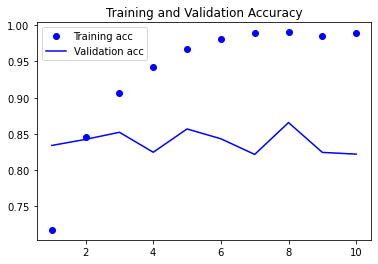

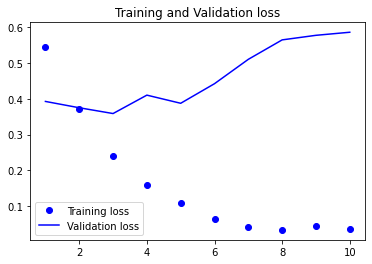

In [7]:
import matplotlib.pyplot as plt

acc = hist.history["acc"]
val_acc = hist.history["val_acc"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and Validation loss")
plt.legend()

plt.show()

전체 시퀀스가 아니라 순서대로 500개의 단어만 입력에 사용했기 때문에 성능이 좋은 편은 아님  
-> `SimpleRNN`이 긴 시퀀스를 처리하는데 적합한 층이 아니기 때문

### LSTM과 GRU 층
`SimpleRNN` 외에 다른 순환 층으로, 실제 많이 사용되는 순환층들임  


`SimpleRNN`은 이론적으로 시간 t에서 이전의 모든 타임스텝의 정보를 유지할 수 있음  
-> 실제로는 긴 시간에 걸친 의존성을 학습할 수 없는 문제가 있음  
-> 층이 많은 일반 네트워크(피드포워드 네트워크)에서 나타나는 것과 비슷한 현상인 **그래디언트 소실 문제(vanishing gradient problem)** 때문  
-> LSTM과 GRU층으로 해결

#### LSTM(Long Short-Trem Memory)
`SimpleRNN`의 변종으로, 여러 타임스텝에 걸쳐 나르는 방법이 추가됨  
-> 나중을 위해 정보를 저장함으로써 처리 과정에서 오래된 시그널이 점차 손실되는 것을 막아줌  

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import tensorflow as tf

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation="sigmoid"))

model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["acc"]
)

with tf.device(":/GPU:0"):
    hist = model.fit(input_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 19s 27ms/step - loss: 0.5186 - acc: 0.7528 - val_loss: 0.3503 - val_acc: 0.8536
Epoch 2/10
157/157 [==============================] - 4s 24ms/step - loss: 0.3001 - acc: 0.8813 - val_loss: 0.3621 - val_acc: 0.8580
Epoch 3/10
157/157 [==============================] - 4s 26ms/step - loss: 0.2389 - acc: 0.9099 - val_loss: 0.3194 - val_acc: 0.8642
Epoch 4/10
157/157 [==============================] - 4s 25ms/step - loss: 0.2020 - acc: 0.9254 - val_loss: 0.2874 - val_acc: 0.8850
Epoch 5/10
157/157 [==============================] - 4s 27ms/step - loss: 0.1797 - acc: 0.9358 - val_loss: 0.3162 - val_acc: 0.8700
Epoch 6/10
157/157 [==============================] - 4s 26ms/step - loss: 0.1618 - acc: 0.9424 - val_loss: 0.4015 - val_acc: 0.8738
Epoch 7/10
157/157 [==============================] - 4s 25ms/step - loss: 0.1451 - acc: 0.9486 - val_loss: 0.3414 - val_acc: 0.8846
Epoch 8/10
157/157 [==============================] - 4s 25ms/step -

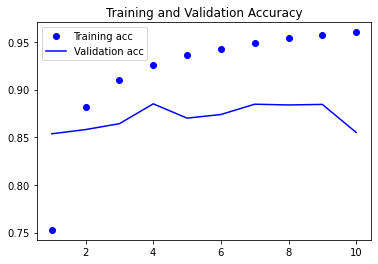

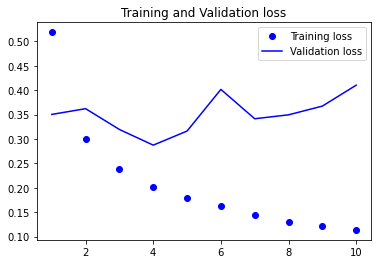

In [3]:
import matplotlib.pyplot as plt

acc = hist.history["acc"]
val_acc = hist.history["val_acc"]
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and Validation loss")
plt.legend()

plt.show()

### 순환 신경망의 고급 사용법
1. 순환 드롭아웃(recurrent dropout): 순환층에서 과대적합을 방지하기 위해 사용
2. 스태킹 순환층(stacking recurrent layer): 네트워크의 표현 능력(representational power)을 증가 (계산 비용 증가)
3. 양방향 순환층(bidirectional recurrent layer): 순환 네트워크에 같은 정보를 다른 방향으로 주입해 정확도를 높이고 기억을 좀 더 오래 유지

#### 기온 예측 문제
14개의 관측치가 10분 간격으로 기록되어있음  

In [1]:
import os

data_dir = "./"
fname = os.path.join(data_dir, "jena_climate_2009_2016.csv")

f = open(fname)
data = f.read()
f.close()

In [2]:
lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]

In [3]:
print(header)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']


In [3]:
print(len(lines))

420451


In [4]:
# 데이터 파싱
import numpy as np

float_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    float_data[i,:] = values

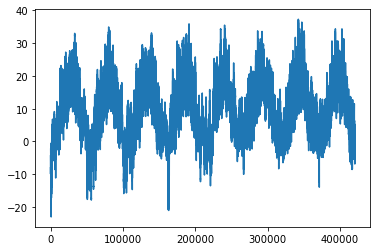

In [10]:
# 시계열 온도 그래프
temp = float_data[:, 1]
plt.plot(range(len(temp)), temp);

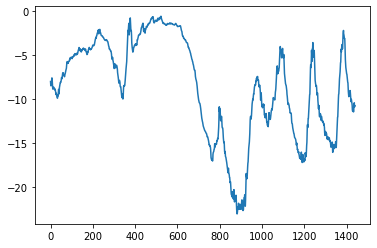

In [11]:
# 처음 10일간 온도 그래프
plt.plot(range(1440), temp[:1440]);

In [5]:
# 데이터 정규화
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [6]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    """제너레이터 함수

    Args:
        data (float): 정규화된 원본 데이터
        lookback (int): 입력으로 사용하기 위해 거슬러 올라갈 타임스텝
        delay (int): 타깃으로 사용할 미래의 타임스텝
        min_index (int): data 배열의 idx
        max_index (int): data 배열의 idx
    """
    if max_index is None:
        max_index = len(data) - delay - 1
    idx = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index+lookback, max_index, size=batch_size)
        else:
            if idx+batch_size >= max_index:
                idx = min_index+lookback
            rows = np.arange(idx, min(idx+batch_size, max_index))
            idx += len(rows)

        samples = np.zeros((len(rows), lookback//step, data.shape[-1]))
        targets = np.zeros((len(rows)))
        for j, row in enumerate(rows):
            indices = range(rows[j]-lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j]+delay][1]
        yield samples, targets

In [7]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle=True, step=step, batch_size=batch_size)
val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000, step=step, batch_size=batch_size)
test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None, step=step, batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 -lookback) // batch_size

In [19]:
# 기준 모델의 MAE 계산
def evaluate_native_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds-targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

evaluate_native_method()

0.2897359729905486


평균 절대 오차(MAE)에 표준 편차를 곱하면 섭씨 온도가 됨

In [21]:
celsius_mae = 0.29*std[1]
celsius_mae

2.5672247338393395

#### 기본적인 모델

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback//step, float_data.shape[-1])))
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(1))

model.compile(
    optimizer=RMSprop(),
    loss = "mae"
)

with tf.device(":/GPU:0"):
    hist = model.fit(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 12s 22ms/step - loss: 1.0671 - val_loss: 0.5512
Epoch 2/20
500/500 [==============================] - 11s 22ms/step - loss: 0.3515 - val_loss: 0.3175
Epoch 3/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2845 - val_loss: 0.3278
Epoch 4/20
500/500 [==============================] - 12s 24ms/step - loss: 0.2646 - val_loss: 0.3039
Epoch 5/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2515 - val_loss: 0.3034
Epoch 6/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2425 - val_loss: 0.3265
Epoch 7/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2343 - val_loss: 0.3303
Epoch 8/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2296 - val_loss: 0.3159
Epoch 9/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2243 - val_loss: 0.3122
Epoch 10/20
500/500 [==============================] - 11s 22ms/step - loss: 0.220

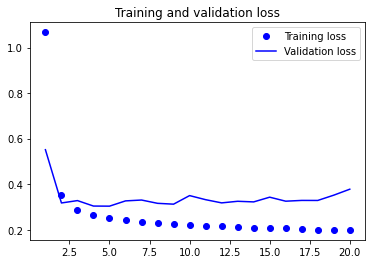

In [23]:
import matplotlib.pyplot as plt

loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(1, len(loss)+1)

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

#### GRU (Gated Recurrent Unit)  
`LSTM`과 같은 원리로 작동하지만 조금 더 간결해 계산 비용이 더 듬  
-> LSTM만큼 표현 학습 능력이 높지 않을 수 있음  

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(
    optimizer=RMSprop(),
    loss="mae"
)

with tf.device(":/GPU:0"):
    hist = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20


C:\Users\spec3\AppData\Local\Temp\ipykernel_7480\3484468824.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)


500/500 [==============================] - 20s 22ms/step - loss: 0.3033 - val_loss: 0.2706
Epoch 2/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2838 - val_loss: 0.2674
Epoch 3/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2790 - val_loss: 0.2674
Epoch 4/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2719 - val_loss: 0.2670
Epoch 5/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2683 - val_loss: 0.2658
Epoch 6/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2622 - val_loss: 0.2659
Epoch 7/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2578 - val_loss: 0.2686
Epoch 8/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2549 - val_loss: 0.2713
Epoch 9/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2490 - val_loss: 0.2750
Epoch 10/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2458 - val_los

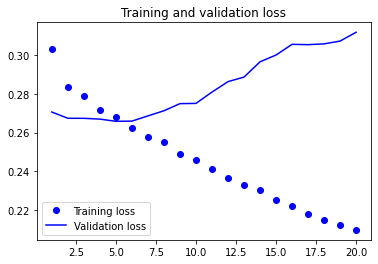

In [12]:
import matplotlib.pyplot as plt

loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(1, len(loss)+1)

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

#### 과대 적합을 감소하기 위해 순환 드롭아웃 사용하기
우연한 상관관계를 깨뜨리기 위해 입력 층의 유닛을 랜덤하게 끄는 기법  
-> 순환층 이전에 드롭아웃을 적용하면 규제에 도움이 되는 것보다 학습에 방해되는 것으로 알려져 있음  
-> 동일한 드롭아웃 마스크를 모든 타입스텝에 적용해야 함  

In [12]:
model = Sequential()
model.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(
    optimizer=RMSprop(),
    loss="mae"
)

with tf.device(":/GPU:0"):
    hist = model.fit(train_gen, steps_per_epoch=500, epochs=40, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 927s 2s/step - loss: 0.3233 - val_loss: 0.2853
Epoch 2/40
500/500 [==============================] - 907s 2s/step - loss: 0.3052 - val_loss: 0.2752
Epoch 3/40
500/500 [==============================] - 908s 2s/step - loss: 0.3009 - val_loss: 0.2868
Epoch 4/40
500/500 [==============================] - 911s 2s/step - loss: 0.2959 - val_loss: 0.2745
Epoch 5/40
500/500 [==============================] - 903s 2s/step - loss: 0.2911 - val_loss: 0.2710
Epoch 6/40
500/500 [==============================] - 916s 2s/step - loss: 0.2868 - val_loss: 0.2829
Epoch 7/40
500/500 [==============================] - 912s 2s/step - loss: 0.2833 - val_loss: 0.2707
Epoch 8/40
500/500 [==============================] - 899s 2s/step - loss: 0.2779 - val_loss: 0.2734
Epoch 9/40
500/500 [==============================] - 916s 2s/step - loss: 0.2763 - val_loss: 0.2705
Epoch 10/40
500/500 [==============================] - 928s 2s/step - loss: 0.2712 - val_lo

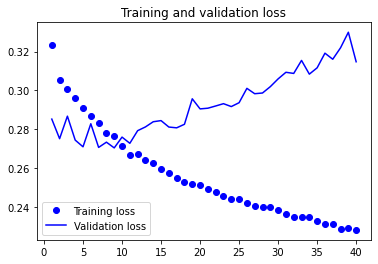

In [14]:
import matplotlib.pyplot as plt

loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(1, len(loss)+1)

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

#### 스태킹 순환층
네트워크의 용량을 늘리려면 일반적으로 층에 있는 유닛의 수를 늘리거나 층을 더 많이 추가해야 함  
-> 순환층을 차례대로 쌓으려면 모든 중간층은 마지막 타임스텝 출력만 아니고 전체 시퀀스를 출력해야 함 (`return_sequences=True`)

In [ ]:
model = Sequential()
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5, return_sequences=True, input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation="relu", dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(
    optimizer=RMSprop(),
    loss="mae"
)

with tf.device(":/GPU:0"):
    hist = model.fit_generator(train_gen, steps_per_epoch=500, epochs=40, validation_data=val_gen, validation_steps=val_steps)

In [ ]:
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(1, len(loss)+1)

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

#### 양방향 RNN 사용하기 (bidirectional RNN)
양방향 RNN은 RNN의 변종이고 특정 작업에서 기본 RNN보다 훨씬 좋은 성능을 냄  
-> 양방향 RNN은 RNN이 순서에 민감하다는 성질을 사용  
-> RNN 2개를 사용해, 입력 시퀀스를 한 방향으로 처리한 후 각 표현을 합침  
-> 시퀀스를 양쪽 방향으로 처리하기 때문에 양방향 RNN은 단방향 RNN이 놓치기 쉬운 패턴을 감지할 수 있음

In [17]:
model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])
))
model.add(layers.Dense(1))

model.compile(
    optimizer=RMSprop(),
    loss="mae"
)

with tf.device(":/GPU:0"):
    hist = model.fit_generator(train_gen, steps_per_epoch=500, epochs=40, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/40


C:\Users\spec3\AppData\Local\Temp\ipykernel_28272\540890475.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(train_gen, steps_per_epoch=500, epochs=40, validation_data=val_gen, validation_steps=val_steps)


500/500 [==============================] - 29s 38ms/step - loss: 0.2937 - val_loss: 0.2795
Epoch 2/40
500/500 [==============================] - 19s 37ms/step - loss: 0.2768 - val_loss: 0.2744
Epoch 3/40
500/500 [==============================] - 19s 37ms/step - loss: 0.2701 - val_loss: 0.2736
Epoch 4/40
500/500 [==============================] - 18s 35ms/step - loss: 0.2660 - val_loss: 0.2698
Epoch 5/40
500/500 [==============================] - 18s 36ms/step - loss: 0.2581 - val_loss: 0.2658
Epoch 6/40
500/500 [==============================] - 18s 36ms/step - loss: 0.2521 - val_loss: 0.2685
Epoch 7/40
500/500 [==============================] - 21s 42ms/step - loss: 0.2482 - val_loss: 0.2864
Epoch 8/40
500/500 [==============================] - 23s 47ms/step - loss: 0.2403 - val_loss: 0.2800
Epoch 9/40
500/500 [==============================] - 24s 49ms/step - loss: 0.2358 - val_loss: 0.2858
Epoch 10/40
500/500 [==============================] - 18s 36ms/step - loss: 0.2275 - val_los

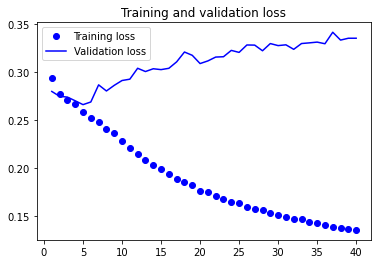

In [18]:
loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

epochs = range(1, len(loss)+1)

plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()